In [ ]:
import os
from pathlib import Path
import pandas as pd

os.environ["OPENBLAS_NUM_THREADS"] = "1"

# --- CẤU HÌNH ---
INPUT_CSV = Path("Dataset/ET1_K62_K63_K64.csv")
OUTPUT_XLSX = Path("Data_clean/Data_subject_pivot.xlsx")
REQUIRED_COURSES = [
    "Giải tích II", "Giải tích I", "Phương pháp tính", "Đại số", "Giải tích III",
    "Xác suất thống kê", "Vật lý đại cương II", "Vật lý đại cương I", "Tin học đại cương", "Vật lý điện tử",
    "Nhập môn kỹ thuật điện tử-viễn thông",
    "Thực tập cơ bản",
    "Technical Writing and Presentation",
    "Kỹ thuật lập trình C/C++",
    "Cấu kiện điện tử",
    "Lý thuyết mạch",
    "Tín hiệu và hệ thống",
    "Lý thuyết thông tin",
    "Cơ sở kỹ thuật đo lường",
    "Cấu trúc dữ liệu và giải thuật",
    "Trường điện từ",
    "Điện tử số",
    "Điện tử tương tự I",
    "Điện tử tương tự II",
    "Thông tin số",
    "Kỹ thuật phần mềm ứng dụng",
    "Anten và truyền sóng",
    "Đồ án thiết kế I",
    "Kỹ thuật vi xử lý",
    "Đồ án thiết kế II",
    "Xử lý tín hiệu số",
    "Lý thuyết mật mã",
    "Cơ sở truyền số liệu",
    "Mạng máy tính",
    "Hệ thống viễn thông",
    "Hệ điều hành",
    "Thông tin vô tuyến",
    "Cơ sở điện sinh học",
    "Cảm biến và KT đo lường y sinh",
    "Thiết bị điện tử y sinh I",
    "Giải phẫu và sinh lý học",
    "Mạch xử lý tín hiệu y sinh",
    "Công nghệ chẩn đoán hình ảnh I",
    "Đa phương tiện",
    "Kỹ thuật truyền hình",
    "Thiết kế IC tương tự",
    "Thiết kế VLSI",
    "Kiểm chứng và kiểm tra vi mạch",
    "Hệ thống nhúng và thiết kế giao tiếp nhúng"
]
GRADE_MAPPING = {
    'A+': 4.0, 'A': 4.0, 'B+': 3.5, 'B': 3.0,
    'C+': 2.5, 'C': 2.0, 'D+': 1.5, 'D': 1.0
}

# --- HÀM CHÍNH ---
def process_grades(input_csv: Path, output_xlsx: Path):
    print(f"🔍 Đang đọc dữ liệu từ: {input_csv}")
    df = pd.read_csv(input_csv)

    # Chọn cột cần thiết
    needed_columns = ["EncryptedID", "Course ID", "Course Name", "Final Grade"]
    missing_cols = [c for c in needed_columns if c not in df.columns]
    if missing_cols:
        raise ValueError(f"Các cột sau thiếu trong file nguồn: {missing_cols}")
    df_cleaned = df[needed_columns].copy()
    

    # Map điểm chữ sang số
    df_cleaned["Final Grade Numeric"] = df_cleaned["Final Grade"].map(GRADE_MAPPING)

    # Báo nếu có grade không hợp lệ
    invalid_grades = df_cleaned["Final Grade"].isna() & df_cleaned["Final Grade Numeric"].isna()
    if invalid_grades.any():
        count_invalid = invalid_grades.sum()
        print(f"⚠️ Có {count_invalid} dòng có 'Final Grade' không nằm trong mapping và sẽ bị loại (ví dụ: {df_cleaned.loc[invalid_grades, 'Final Grade'].unique()[:5]})")

    # Loại bỏ NaN sau khi map (chỉ giữ những grade hợp lệ)
    df_cleaned = df_cleaned.dropna(subset=["Final Grade Numeric"])

    # Lọc các môn cần thiết (nếu Course Name trùng)
    df_filtered = df_cleaned[df_cleaned["Course Name"].isin(REQUIRED_COURSES)].copy()
    print(f"✅ Sau khi lọc theo danh sách môn: còn {len(df_filtered)} dòng.")

    # Lấy điểm tốt nhất của mỗi sinh viên cho mỗi môn
    df_best = (
        df_filtered
        .groupby(["EncryptedID", "Course ID", "Course Name"], dropna=False)["Final Grade Numeric"]
        .max()
        .reset_index()
    )
    
    # Pivot dùng best scores
    pivot_df = df_best.pivot_table(
        index="EncryptedID",
        columns="Course Name",
        values="Final Grade Numeric",
        aggfunc="first"  # đã là max rồi
    )

    # Đảm bảo thứ tự cột theo REQUIRED_COURSES, nhưng chỉ lấy những course thực sự có trong dữ liệu
    existing_cols = [c for c in REQUIRED_COURSES if c in pivot_df.columns]
    pivot_df = pivot_df.reindex(columns=existing_cols)
    pivot_df = pivot_df.reset_index()

    # Tạo thư mục đầu ra nếu chưa có
    output_xlsx.parent.mkdir(parents=True, exist_ok=True)
    pivot_df.to_excel(output_xlsx, index=False)
    print(f"✅ Đã lưu bảng xoay (pivot) vào: {output_xlsx}")

if __name__ == "__main__":
    process_grades(INPUT_CSV, OUTPUT_XLSX)


🔍 Đang đọc dữ liệu từ: Dataset\ET1_K62_K63_K64.csv
✅ Sau khi lọc theo danh sách môn: còn 52812 dòng.
✅ Đã lưu bảng xoay (pivot) vào: Data_clean\Data_subject_pivot.xlsx


In [1]:
import os
from pathlib import Path
import pandas as pd

os.environ["OPENBLAS_NUM_THREADS"] = "1"

INPUT = Path("Data_clean/Data_subject_pivot.xlsx")
OUTPUT = Path("Data_clean/Data_subject_complete.xlsx")

REQUIRED_COURSES = [
    "Giải tích II", "Giải tích I", "Phương pháp tính", "Đại số", "Giải tích III",
    "Xác suất thống kê", "Vật lý đại cương II", "Vật lý đại cương I", "Tin học đại cương", "Vật lý điện tử",
    "Nhập môn kỹ thuật điện tử-viễn thông",
    "Thực tập cơ bản",
    "Technical Writing and Presentation",
    "Kỹ thuật lập trình C/C++",
    "Cấu kiện điện tử",
    "Lý thuyết mạch",
    "Tín hiệu và hệ thống",
    "Lý thuyết thông tin",
    "Cơ sở kỹ thuật đo lường",
    "Cấu trúc dữ liệu và giải thuật",
    "Trường điện từ",
    "Điện tử số",
    "Điện tử tương tự I",
    "Điện tử tương tự II",
    "Thông tin số",
    "Kỹ thuật phần mềm ứng dụng",
    "Anten và truyền sóng",
    "Đồ án thiết kế I",
    "Kỹ thuật vi xử lý",
    "Đồ án thiết kế II",
    "Xử lý tín hiệu số",
]

# Đọc dữ liệu
df = pd.read_excel(INPUT)

# Giữ chỉ EncryptedID và những môn thực sự có trong file
available_courses = [c for c in REQUIRED_COURSES if c in df.columns]
keep_cols = ["EncryptedID"] + available_courses
df = df[keep_cols].copy()

# Lọc chỉ sinh viên có đầy đủ điểm (không có NaN ở tất cả các môn)
df_complete = df.dropna(subset=available_courses, how="any")  # tương đương với: ~df[available_courses].isna().any(axis=1)

df_complete = df_complete.sample(frac=1, random_state=42).reset_index(drop=True)
n = len(df_complete)
n_train = int(n * 0.7)
n_val = int(n * 0.15)
n_test = n - n_train - n_val

split_col = (
    ["train"] * n_train + 
    ["val"] * n_val + 
    ["test"] * n_test
)

df_complete["split"] = split_col



# Ghi ra file
OUTPUT.parent.mkdir(parents=True, exist_ok=True)
df_complete.to_excel(OUTPUT, index=False)
print(f"✅ Đã xuất sinh viên đủ tất cả môn (chỉ ID + môn) vào: {OUTPUT}")


✅ Đã xuất sinh viên đủ tất cả môn (chỉ ID + môn) vào: Data_clean\Data_subject_complete.xlsx


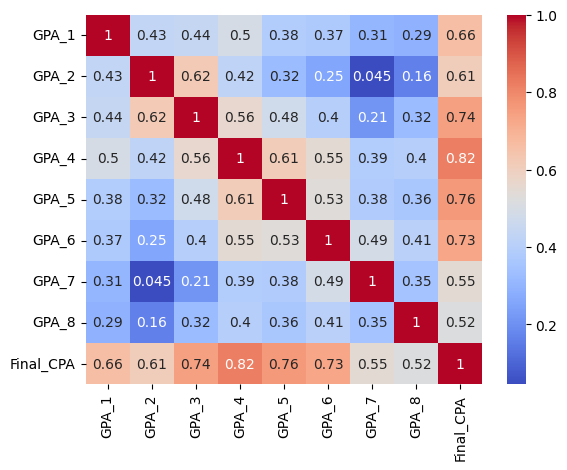

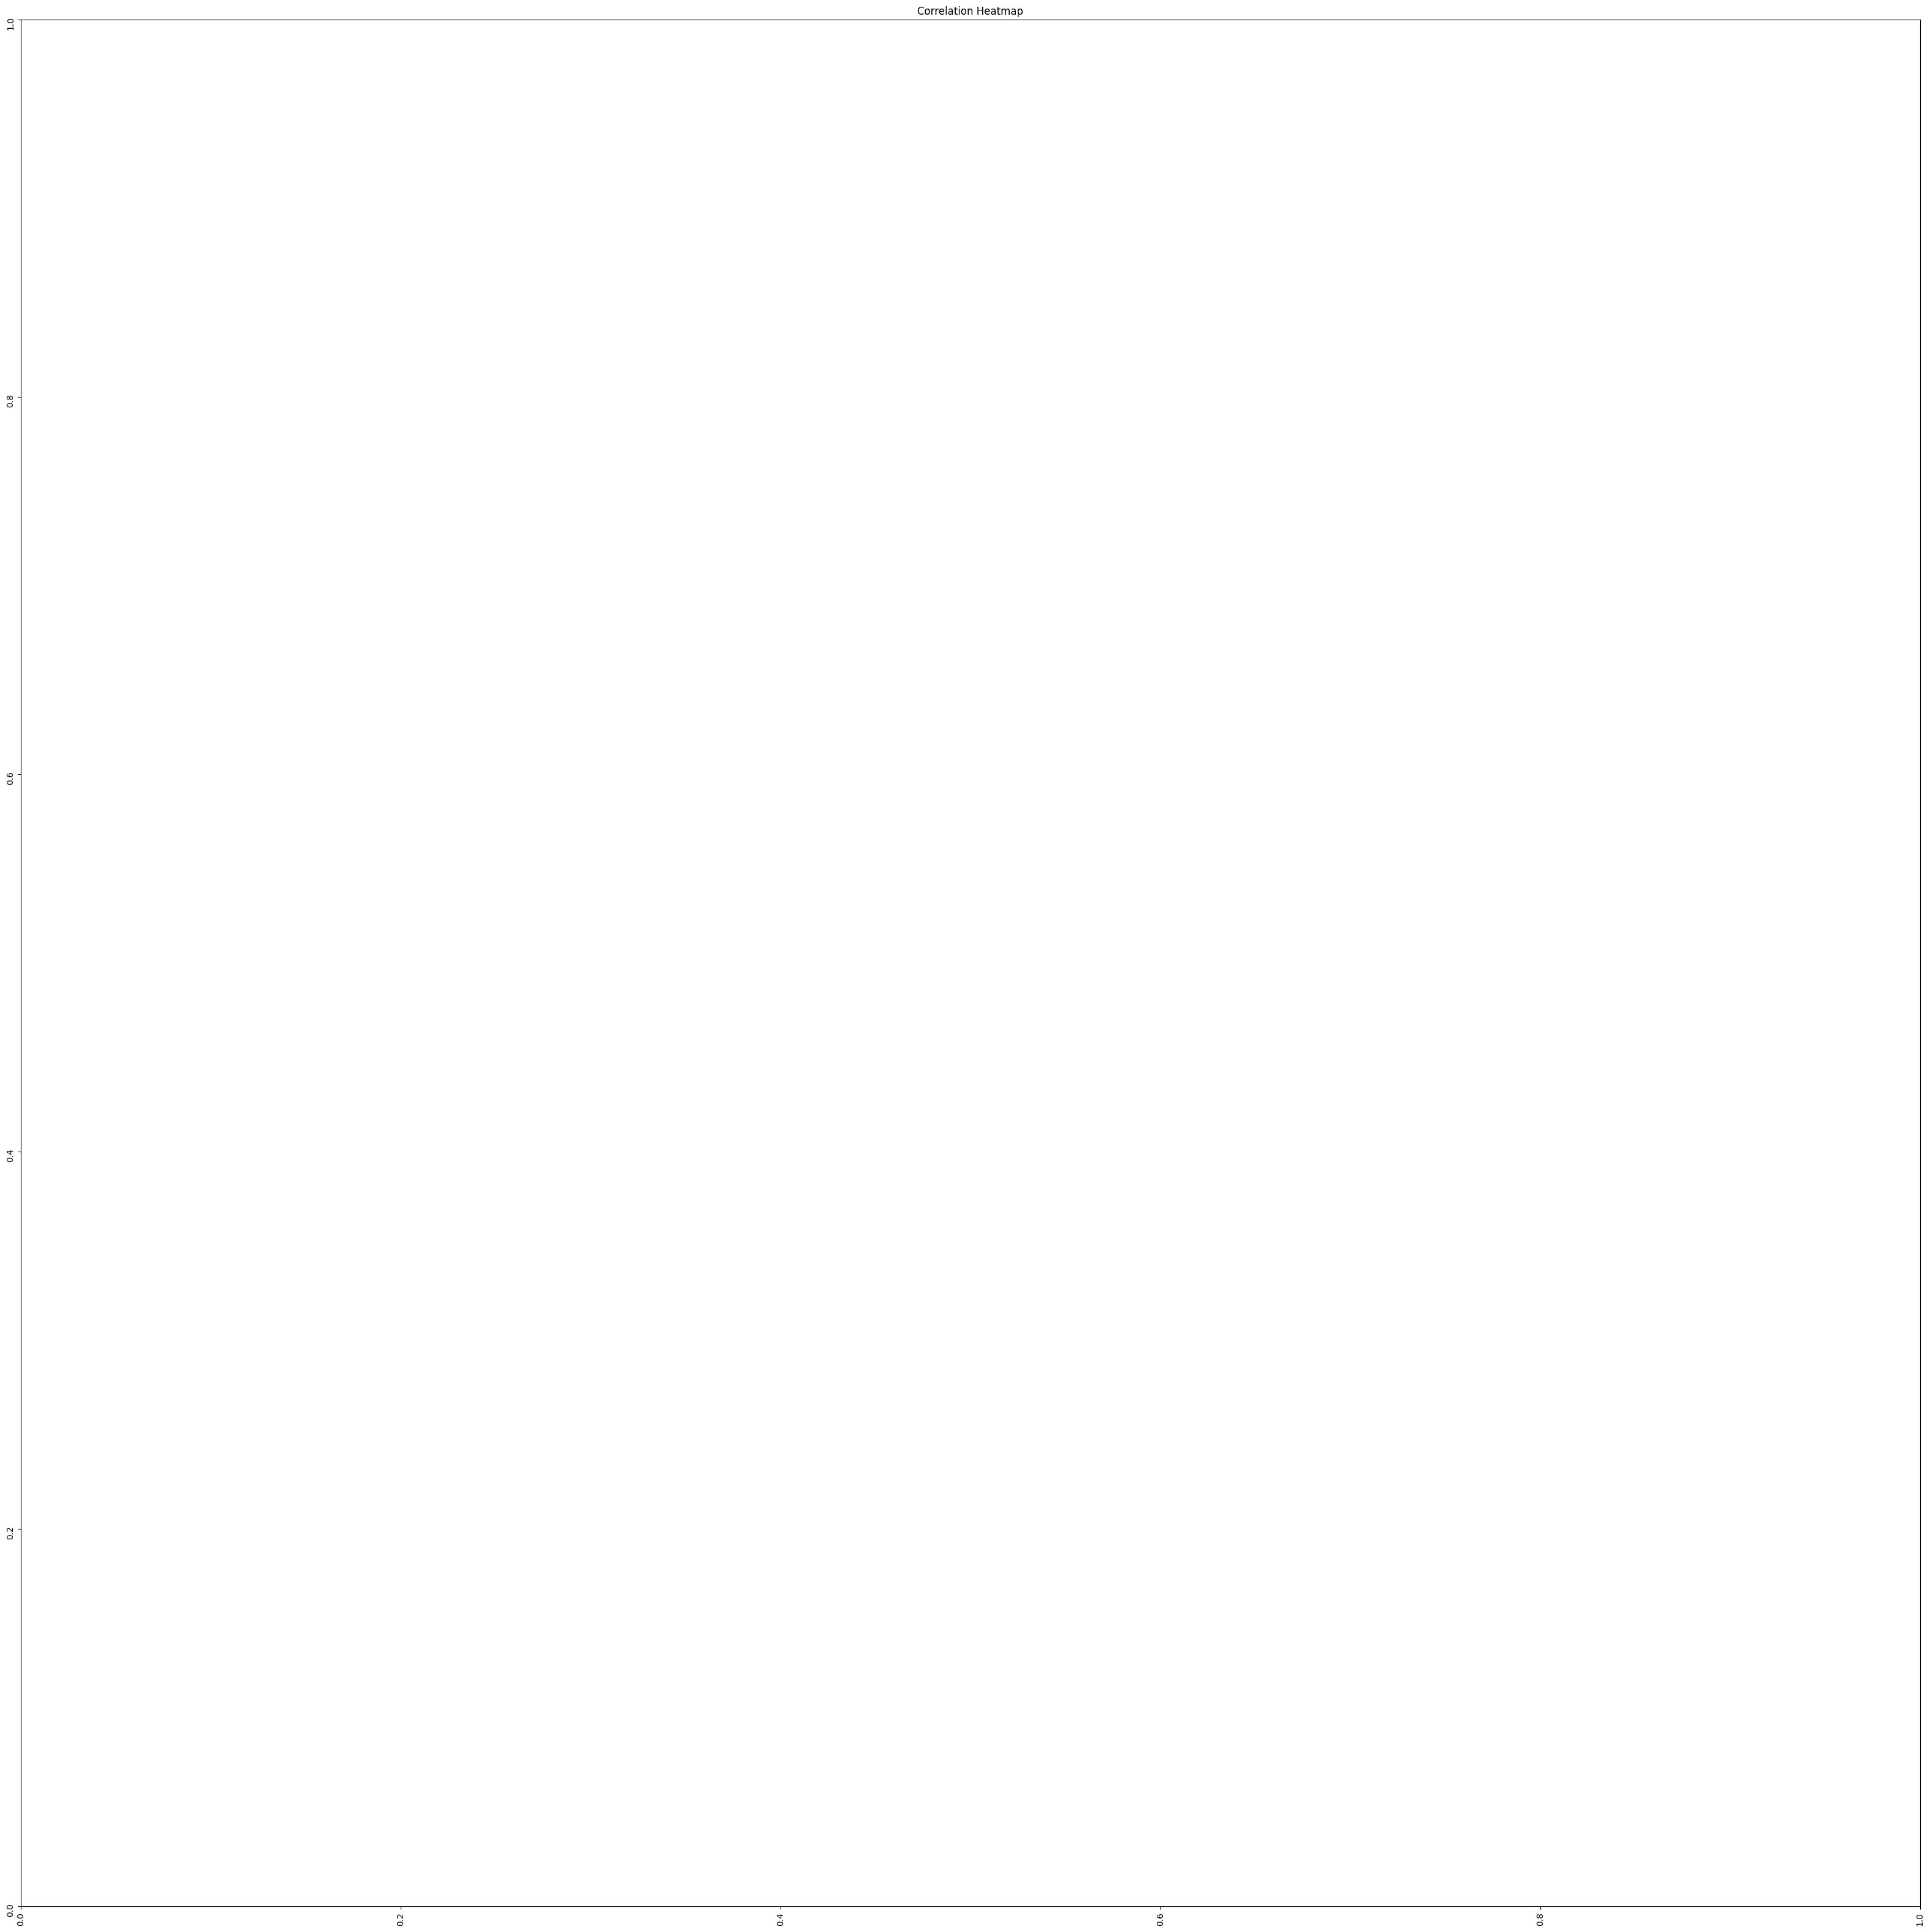

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_excel("Data_clean\Data_GPA_CPA_final_8_ky.xlsx")

danh_sach_mon = [col for col in df.columns if col not in ['EncryptedID', 'Final CPA', 'TC_qua_1', 'TC_qua_2', 'TC_qua_3', 'TC_qua_4', 'TC_qua_5', 'TC_qua_6', 'TC_qua_7', 'TC_qua_8', 'TC_LK_1', 'TC_LK_2', 'TC_LK_3', 'TC_LK_4', 'TC_LK_5', 'TC_LK_6', 'TC_LK_7', 'TC_LK_8']]
sns.heatmap(df[danh_sach_mon].corr(), annot=True, cmap='coolwarm')
plt.figure(figsize=(40,40))  # tùy chỉnh chiều rộng và chiều cao
# sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')

plt.title('Correlation Heatmap')
plt.yticks(rotation=90)
plt.xticks(rotation=90)
plt.show()